In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import matplotlib.pyplot as plt
import ast
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
import seaborn as sns
from sklearn.model_selection import train_test_split

csv_path = '/content/drive/My Drive/Edge/Full_Dataset.csv'
#pkl_path = '/content/drive/My Drive/Edge/Full_Dataset.pkl'

df = pd.read_csv(csv_path)
pd.set_option('display.max_columns', None)

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6)
})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Goals of Method 2
The overarching goal of this method is to group ETFs with similar performance, risk, sector exposure, and other characteristics into clusters. These clusters can then be analyzed to identify the key features driving each group and matched to investor profiles. The purpose of clustering is to reduce redundancy in ETF portfolios, provide transparency, and align investments with personal goals such as risk tolerance, budget, and ethical considerations. This can be done in a couple of ways.

## Part 1: PCA and KNN Approach
We first use PCA followed by KNN, where we then interpret the key features involved in the relevant components separating the cluster centroids. The methodology for this first part is as follows:

1. Dimensionality Reduction for Holdings:
  - Initially, we explored ways to incorporate the exact holdings of ETFs into our clustering process. The idea was to use principal component analysis (PCA) to reduce the high dimensionality of unique holdings across ETFs while retaining the most relevant variance.
  - However, when reducing the dimensions of holdings (e.g., 100 components), the PCA output for holdings dominated the variance explanation in the overarching PCA step, overshadowing other important features (e.g., risk metrics, expense ratios).
  - Decision: To avoid this issue, we focused instead on the sector breakdown columns (e.g., sector_consumer_cyclical, sector_energy) as a proxy for holdings. This provides a simpler and interpretable representation of ETF composition without overwhelming the analysis.

2. Overarching PCA for ETF Features:
  - We applied PCA to a comprehensive set of ETF features, including:
Numeric Features: Performance and risk metrics (drawdown, volatility, avg_monthly_return), sector breakdowns, expense ratios (ter), and inception date converted into monthsSinceInception.
  - Categorical Features: Fund provider and fund currency, which were one-hot encoded to include each category as a separate column.
PCA was used to transform these high-dimensional features into a smaller number of principal components, each capturing the most significant variance in the dataset.

3. Selection of Principal Components:
  - We analyzed the explained variance ratio and selected the number of components required to explain at least 90% of the variance. This resulted in a reduced feature set representing a combination of the most important characteristics of ETFs.

4. Clustering via KMeans:
  - After reducing the dimensionality of the data, we applied KMeans clustering to group ETFs based on their similarity in the PCA-transformed feature space.
  - The optimal number of clusters was selected using the elbow method, which identifies the point where the sum of squared distances within clusters begins to level off. For this dataset, 6 clusters were chosen.

5. Interpreting the Clusters:
  - Each cluster in KMeans has a cluster center in the PCA space. These centers represent the average values of the principal components for all ETFs in that cluster.
  - The PCA inverse transform takes the cluster centers from the PCA space and maps them back to the original feature space. This means we "reconstruct" what the cluster center looks like in terms of the original ETF features, like sector_technology, drawdown, or ter.
  - Once we have the cluster centers in the original feature space, we create a table where each row corresponds to a cluster, and each column corresponds to an original feature. These values show the average for each feature within a cluster. To identify the features that best distinguish the clusters, we calculate the range (difference between the maximum and minimum values) of each feature across all clusters.
  - Features with the largest ranges are the most "differentiating," meaning they vary significantly between clusters and are likely key drivers of the clustering.

Results identifying the top original features corresponding to PCs dictating the clustering will be discussed below.

In [2]:
df['inceptionDate'] = pd.to_datetime(df['inceptionDate'])
current_date = datetime(2024, 12, 1)
df['monthsSinceInception'] = ((current_date - df['inceptionDate']).dt.days // 30)

categorical_cols = ['fundProvider', 'fundCurrency']
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_data = encoder.fit_transform(df[categorical_cols])
categorical_feature_names = encoder.get_feature_names_out(categorical_cols).tolist()

numeric_cols = [
    'quote', 'ter', 'maxAge', 'cashPosition', 'stockPosition', 'bondPosition', 'otherPosition',
    'preferredPosition', 'convertiblePosition', 'priceToEarnings', 'priceToBook', 'priceToSales',
    'priceToCashflow', 'sector_realestate', 'sector_consumer_cyclical', 'sector_basic_materials',
    'sector_consumer_defensive', 'sector_technology', 'sector_communication_services',
    'sector_financial_services', 'sector_utilities', 'sector_industrials', 'sector_energy',
    'sector_healthcare', 'Var', 'drawdown', 'avg_sharpe_ratio', 'beta', 'avg_monthly_return',
    'volatility', 'RSI', 'monthsSinceInception'
]
numeric_data = df[numeric_cols]

general_features = np.hstack([numeric_data, categorical_data])

scaler = StandardScaler()
general_features_scaled = scaler.fit_transform(general_features)

combined_data = general_features_scaled

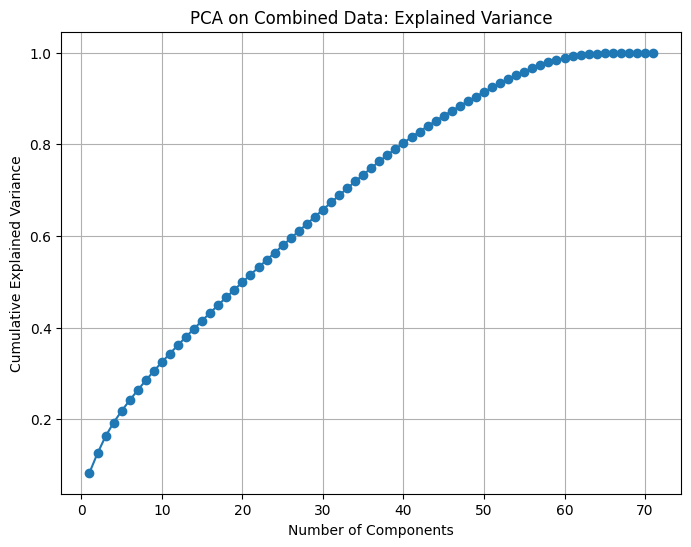

Selected n_components for 90% variance explained: 49


In [3]:

general_features_scaled = np.nan_to_num(general_features_scaled, nan=0.0)


pca_combined = PCA()
combined_pca = pca_combined.fit_transform(general_features_scaled)


explained_variance_ratio_combined = np.cumsum(pca_combined.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio_combined) + 1), explained_variance_ratio_combined, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Combined Data: Explained Variance')
plt.grid()
plt.show()


n_components_general = np.argmax(explained_variance_ratio_combined >= 0.90) + 1
print(f"Selected n_components for 90% variance explained: {n_components_general}")


general_pca_reduced = combined_pca[:, :n_components_general]

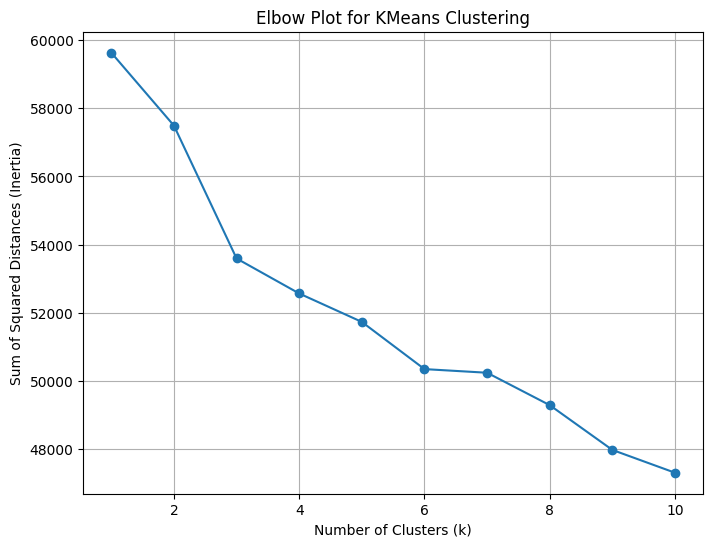

In [4]:
sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(general_pca_reduced)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Plot for KMeans Clustering')
plt.grid()
plt.show()

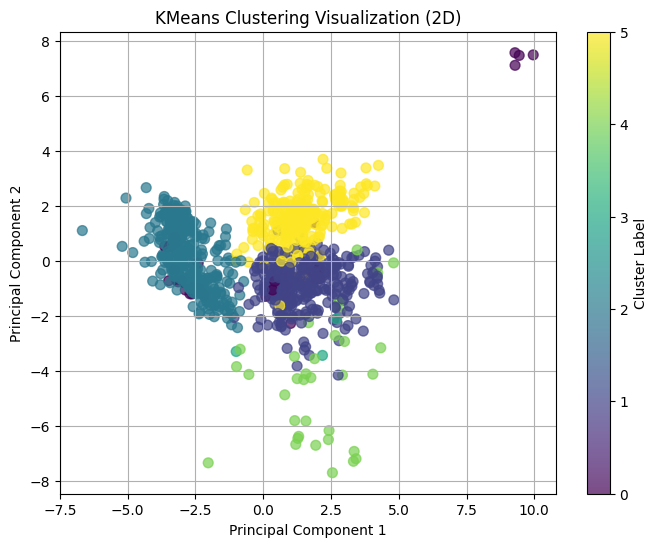

In [5]:
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(general_pca_reduced)

plt.figure(figsize=(8, 6))
plt.scatter(
    general_pca_reduced[:, 0],
    general_pca_reduced[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Visualization (2D)')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

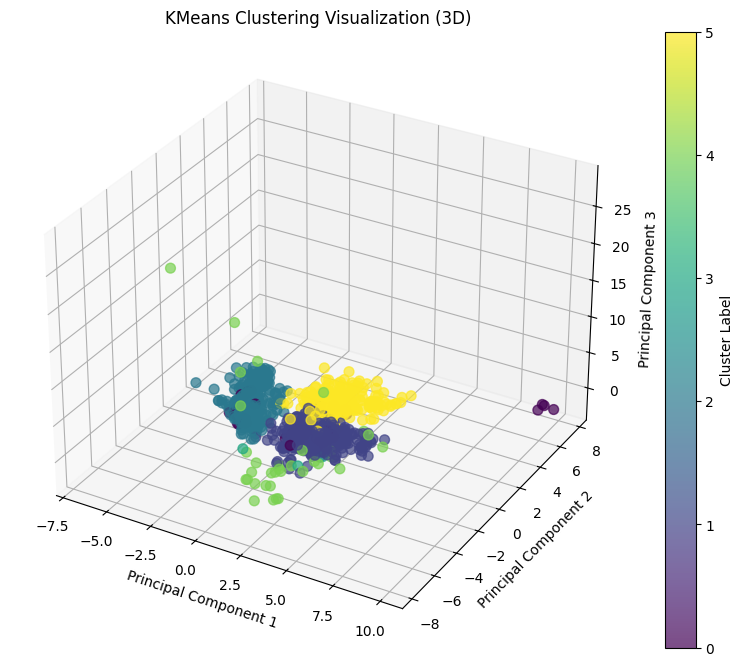

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    general_pca_reduced[:, 0],
    general_pca_reduced[:, 1],
    general_pca_reduced[:, 2],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7
)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('KMeans Clustering Visualization (3D)')
fig.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()

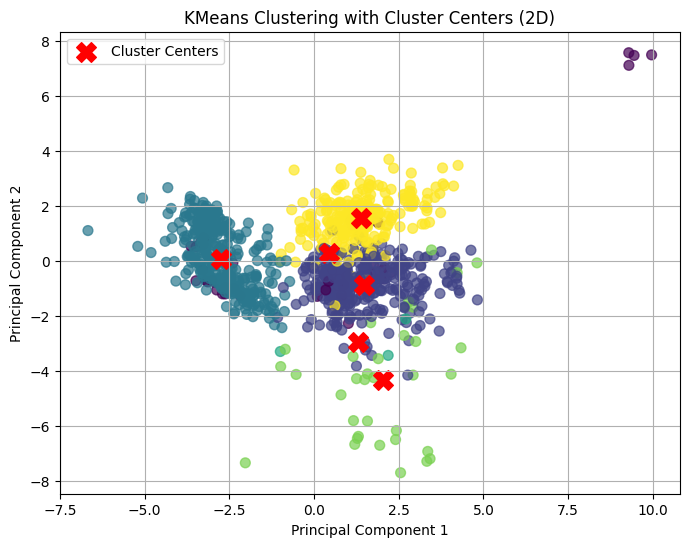

In [7]:
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(
    general_pca_reduced[:, 0],
    general_pca_reduced[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    s=200,
    marker='X',
    label='Cluster Centers'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with Cluster Centers (2D)')
plt.legend()
plt.grid()
plt.show()


Top 10 Most Differentiating Features Across Clusters:
fundProvider_HANetf         18.126121
fundProvider_Vanguard        4.328240
drawdown                     3.252039
Var                          3.139944
fundProvider_Global X        2.682751
ter                          2.628869
sector_consumer_cyclical     2.468303
volatility                   2.170937
fundProvider_CoinShares      2.148256
avg_monthly_return           2.131933
dtype: float64


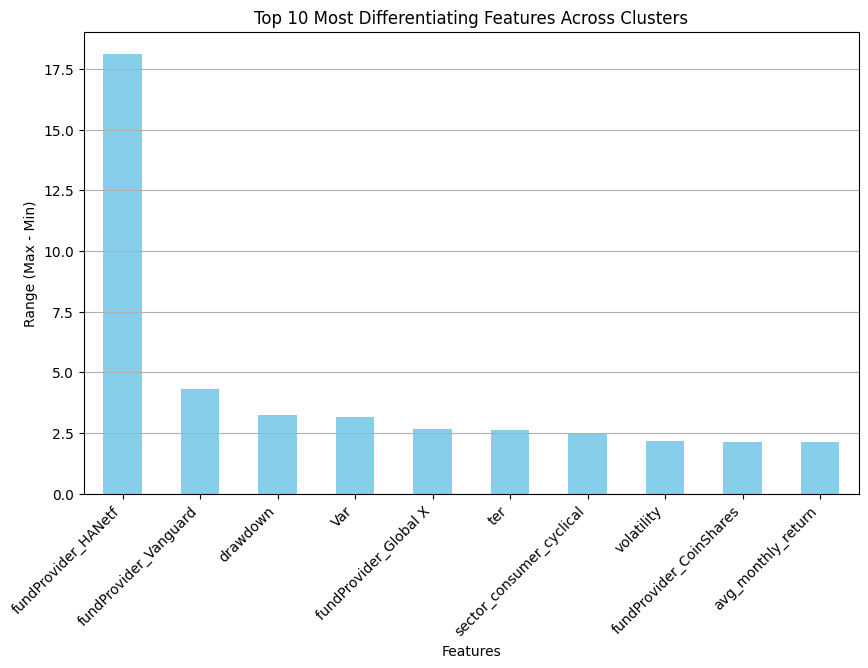

In [8]:
pca_combined = PCA(n_components=n_components_general)
pca_combined.fit(general_features_scaled)

cluster_centers_pca = kmeans.cluster_centers_
cluster_centers_original = pca_combined.inverse_transform(cluster_centers_pca)


cluster_centers_df = pd.DataFrame(
    cluster_centers_original,
    columns=numeric_cols + categorical_feature_names
)


feature_ranges = cluster_centers_df.max() - cluster_centers_df.min()
most_differentiating_features = feature_ranges.nlargest(10)

print("\nTop 10 Most Differentiating Features Across Clusters:")
print(most_differentiating_features)

plt.figure(figsize=(10, 6))
most_differentiating_features.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Differentiating Features Across Clusters')
plt.xlabel('Features')
plt.ylabel('Range (Max - Min)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [9]:
import pandas as pd
import numpy as np
from IPython.display import display


encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(categorical_data, columns=encoded_feature_names, index=df.index)


df_combined = pd.concat([df, encoded_df], axis=1)


df_combined['Cluster'] = cluster_labels


for cluster in range(6):
    print(f"\nCluster {cluster}:")
    cluster_data = df_combined[df_combined['Cluster'] == cluster]

    differentiating_features_present = [
        feature for feature in most_differentiating_features.index if feature in df_combined.columns
    ]
    feature_stats = cluster_data[differentiating_features_present].describe()
    print("Statistics for differentiating features:")
    display(feature_stats)

    print("\nSample ETFs:")
    sample_size = min(len(cluster_data), 5)
    sample_etfs = cluster_data[['name', 'fundProvider', 'fundCurrency']].sample(n=sample_size, random_state=42)
    display(sample_etfs)


Cluster 0:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,49.0,49.000000,49.000000,48.000000,49.0,49.000000,33.000000,48.000000,49.0,49.000000
mean,0.0,0.877551,-0.250299,-0.008985,0.0,0.001782,0.089761,0.007733,0.0,0.007108
std,0.0,0.331201,0.117879,0.004221,0.0,0.001177,0.052272,0.003425,0.0,0.007708
min,0.0,0.000000,-0.458958,-0.017715,0.0,0.000700,0.000000,0.001437,0.0,-0.010560
25%,0.0,1.000000,-0.345888,-0.011492,0.0,0.001000,0.077200,0.004192,0.0,0.001587
50%,0.0,1.000000,-0.235343,-0.010010,0.0,0.001200,0.100200,0.009200,0.0,0.006149
75%,0.0,1.000000,-0.171614,-0.005220,0.0,0.002200,0.134600,0.010488,0.0,0.014151
max,0.0,1.000000,-0.036472,-0.001709,0.0,0.005000,0.156900,0.014348,0.0,0.024173



Sample ETFs:


,name,fundProvider,fundCurrency
159,Vanguard ESG USD Corporate Bond UCITS ETF (USD...,Vanguard,USD
504,iShares USD High Yield Corporate Bond UCITS ET...,iShares,USD
869,Vanguard S&P 500 UCITS ETF,Vanguard,USD
503,iShares USD Short Duration High Yield Corporat...,iShares,USD
343,FlexShares Listed Private Equity UCITS ETF,FlexShares,USD



Cluster 1:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,329.0,329.0,329.000000,322.000000,329.0,329.000000,324.000000,322.000000,329.0,329.000000
mean,0.0,0.0,-0.341742,-0.015287,0.0,0.003384,0.096179,0.012251,0.0,0.011920
std,0.0,0.0,0.128192,0.006008,0.0,0.001908,0.117981,0.003681,0.0,0.009896
min,0.0,0.0,-0.993776,-0.059110,0.0,0.000500,0.000000,0.006208,0.0,-0.022885
25%,0.0,0.0,-0.404690,-0.018065,0.0,0.001900,0.038975,0.010104,0.0,0.006266
50%,0.0,0.0,-0.342544,-0.014311,0.0,0.003000,0.091700,0.011245,0.0,0.012511
75%,0.0,0.0,-0.272522,-0.010867,0.0,0.004900,0.121275,0.013699,0.0,0.016614
max,0.0,0.0,-0.049638,-0.007099,0.0,0.009500,0.990300,0.041116,0.0,0.063544



Sample ETFs:


,name,fundProvider,fundCurrency
261,Xtrackers DAX ESG Screened UCITS ETF 4C CHF He...,Xtrackers,CHF Hedged
734,iShares MSCI USA Quality Dividend ESG UCITS ET...,iShares,USD
703,iShares MSCI Pacific ex-Japan UCITS ETF (Dist),iShares,USD
395,HSBC Emerging Market Sustainable Equity UCITS ...,HSBC ETF,USD
589,Invesco MSCI Emerging Markets UCITS ETF,Invesco,USD



Cluster 2:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,345.0,345.0,345.000000,331.000000,345.0,345.000000,47.000000,331.000000,345.0,344.000000
mean,0.0,0.0,-0.190276,-0.005189,0.0,0.002084,0.093579,0.004313,0.0,0.000547
std,0.0,0.0,0.108929,0.003505,0.0,0.001214,0.212200,0.002633,0.0,0.004792
min,0.0,0.0,-0.578175,-0.017493,0.0,0.000500,0.000000,0.000078,0.0,-0.013514
25%,0.0,0.0,-0.251753,-0.006593,0.0,0.001400,0.000000,0.002627,0.0,-0.002387
50%,0.0,0.0,-0.189984,-0.004616,0.0,0.001700,0.000000,0.003959,0.0,-0.000087
75%,0.0,0.0,-0.111800,-0.002827,0.0,0.002500,0.114650,0.005397,0.0,0.002522
max,0.0,0.0,0.000000,0.000105,0.0,0.007000,1.000000,0.015002,0.0,0.022461



Sample ETFs:


,name,fundProvider,fundCurrency
224,iShares Global Inflation Linked Government Bon...,iShares,EUR Hedged
187,iShares US Aggregate Bond UCITS ETF (Acc),iShares,USD
427,Xtrackers II ESG Global Government Bond UCITS ...,Xtrackers,EUR Hedged
289,iShares eb.rexx Government Germany UCITS ETF (DE),iShares,EUR
827,PIMCO Emerging Markets Advantage Local Bond In...,PIMCO,USD



Cluster 3:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,3.0,3.0,3.000000,3.000000,3.0,3.000000,2.000000,3.000000,3.0,3.000000
mean,1.0,0.0,-0.382479,-0.018516,0.0,0.005600,0.354750,0.015970,0.0,0.018227
std,0.0,0.0,0.171578,0.005605,0.0,0.001473,0.331704,0.002421,0.0,0.010909
min,1.0,0.0,-0.541458,-0.024509,0.0,0.004000,0.120200,0.013205,0.0,0.008468
25%,1.0,0.0,-0.473418,-0.021072,0.0,0.004950,0.237475,0.015102,0.0,0.012338
50%,1.0,0.0,-0.405379,-0.017636,0.0,0.005900,0.354750,0.017000,0.0,0.016208
75%,1.0,0.0,-0.302990,-0.015520,0.0,0.006400,0.472025,0.017353,0.0,0.023106
max,1.0,0.0,-0.200601,-0.013404,0.0,0.006900,0.589300,0.017706,0.0,0.030004



Sample ETFs:


,name,fundProvider,fundCurrency
2,HANetf Alerian Midstream Energy Dividend UCITS...,HANetf,USD
920,HANetf Airlines Hotels Cruise Lines UCITS ETF,HANetf,USD
943,HANetf HAN-GINS Tech Megatrend Equal Weight UC...,HANetf,USD



Cluster 4:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,35.0,35.0,35.000000,35.000000,35.000000,35.000000,21.000000,35.000000,35.000000,35.000000
mean,0.0,0.0,-0.690164,-0.031448,0.228571,0.007334,0.107052,0.374122,0.142857,0.563310
std,0.0,0.0,0.255908,0.021969,0.426043,0.006636,0.122316,0.794737,0.355036,1.331109
min,0.0,0.0,-0.995921,-0.080581,0.000000,0.000000,0.000000,0.008315,0.000000,-0.045457
25%,0.0,0.0,-0.934983,-0.046700,0.000000,0.004500,0.009100,0.015171,0.000000,-0.005784
50%,0.0,0.0,-0.740921,-0.021822,0.000000,0.005000,0.076500,0.030214,0.000000,0.014054
75%,0.0,0.0,-0.458493,-0.014161,0.000000,0.007300,0.170500,0.061601,0.000000,0.080867
max,0.0,0.0,-0.076315,-0.005798,1.000000,0.025000,0.455200,2.907923,1.000000,4.634520



Sample ETFs:


,name,fundProvider,fundCurrency
820,First Trust Nasdaq Clean Edge Green Energy UCI...,First Trust,USD
473,HSBC Hang Seng TECH UCITS ETF HKD,HSBC ETF,HKD
817,First Trust Emerging Markets AlphaDEX UCITS ET...,First Trust,USD
581,Lyxor MSCI China A (DR) UCITS ETF - Acc,Lyxor ETF,USD
523,Global X Cybersecurity UCITS ETF USD Accumulating,Global X,USD



Cluster 5:
Statistics for differentiating features:


,fundProvider_HANetf,fundProvider_Vanguard,drawdown,Var,fundProvider_Global X,ter,sector_consumer_cyclical,volatility,fundProvider_CoinShares,avg_monthly_return
count,260.0,260.0,260.000000,249.000000,260.0,260.000000,259.000000,249.000000,260.0,260.000000
mean,0.0,0.0,-0.343310,-0.012964,0.0,0.002688,0.096627,0.011054,0.0,0.009142
std,0.0,0.0,0.110837,0.003638,0.0,0.001275,0.119543,0.002557,0.0,0.007984
min,0.0,0.0,-0.930194,-0.034501,0.0,0.000500,0.000000,0.005539,0.0,-0.024084
25%,0.0,0.0,-0.399536,-0.014055,0.0,0.001800,0.014650,0.009538,0.0,0.005141
50%,0.0,0.0,-0.355139,-0.012286,0.0,0.002500,0.089700,0.010684,0.0,0.009585
75%,0.0,0.0,-0.302090,-0.010597,0.0,0.003350,0.128700,0.011743,0.0,0.012788
max,0.0,0.0,-0.041174,-0.005257,0.0,0.008000,0.921900,0.027849,0.0,0.073250



Sample ETFs:


,name,fundProvider,fundCurrency
279,Lyxor DJ Global Titans 50 UCITS ETF - Dist,Lyxor ETF,EUR
713,iShares MSCI Target UK Real Estate UCITS ETF,iShares,GBP
960,Deka STOXX Europe 50 UCITS ETF,Deka ETFs,EUR
754,Amundi ETF MSCI World UCITS ETF DR,Amundi ETF,EUR
895,Amundi S&P Global Utilities ESG UCITS ETF DR E...,Amundi ETF,EUR


### Interpretation of Top 10 Differentiating Features Clusters using these Features

Cluster 0:
- Vibe: Primarily dominated by ETFs provided by Vanguard, with a focus on low expense ratios (ter) and moderate volatility. Performance metrics like drawdown and average monthly returns are consistent and relatively steady.
- Example ETFs: Vanguard ESG USD Corporate Bond, Vanguard S&P 500 UCITS.
- Key Features: High representation of fundProvider_Vanguard, low ter, and moderate volatility.
- Ideal User: Long-term, passive investors seeking stability, cost-effectiveness, and broad-market exposure. If they want to stick to one mainstream and accessible brokerage account (Vanguard), this is a good option for them.

Cluster 1:
- Vibe: Broadly diversified ETFs with higher drawdowns and greater variability in performance metrics, indicating more volatile or higher-risk options. No single fund provider dominates this cluster.
- Example ETFs: Xtrackers DAX ESG Screened UCITS, HSBC Emerging Market Sustainable Equity UCITS.
- Key Features: High drawdowns, moderate Var (volatility in returns), and relatively higher average monthly returns compared to other clusters.
- Ideal User: Adventurous investors who want exposure to diverse markets and are willing to accept higher risk for potentially greater returns.

Cluster 2:
- Vibe: A bond-heavy cluster with low drawdowns, low volatility, and minimal average monthly returns. These ETFs are likely more conservative investments focused on stability.
- Example ETFs: iShares Global Inflation Linked Government Bonds, PIMCO Emerging Markets Advantage Local Bond.
- Key Features: Low Var, low volatility, and minimal avg_monthly_return, indicating low-risk bond-focused funds.
- Ideal User: Risk-averse or income-focused investors seeking consistent returns with minimal volatility, such as retirees or those looking for portfolio stability (Bonds are known to be more old school and less risky, less effort).

Cluster 3:
- Vibe: Exclusively HANetf ETFs, focused on niche sectors like energy, technology, or specific market trends. High sector_consumer_cyclical exposure and significant volatility indicate a focus on targeted, high-risk, high-reward strategies.
- Example ETFs: HANetf Alerian Midstream Energy Dividend, HANetf Airlines Hotels Cruise Lines.
- Key Features: Strong representation of fundProvider_HANetf, high sector_consumer_cyclical exposure, and high volatility.
- Ideal User: Trend-following or thematic investors interested in high-growth opportunities in emerging markets and innovative sectors, focus on environment and other niche sectors.

Cluster 4:
- Vibe: A highly volatile and aggressive investment cluster, featuring Global X funds alongside niche thematic ETFs. These ETFs focus on emerging markets or innovative sectors like green energy or cybersecurity.
- Example ETFs: First Trust Nasdaq Clean Edge Green Energy, Global X Cybersecurity UCITS.
- Key Features: High volatility, higher avg_monthly_return, and strong presence of fundProvider_Global X.
- Ideal User: Impact-focused investors who want high-growth potential with a thematic approach, such as ESG or technology-focused funds.

Cluster 5:
- Vibe: Moderately stable ETFs, with balanced drawdowns and volatility. These funds often have a European focus, as indicated by their currencies (EUR, GBP) and providers like Lyxor and Amundi.
- Example ETFs: Lyxor DJ Global Titans 50 UCITS, Amundi MSCI World UCITS ETF DR.
Key Features: Moderate Var and volatility, with no single dominant fund provider.
- Ideal User: Diversified global (European) investors seeking moderate-risk exposure with an emphasis on European markets and balanced sector representation.


## Part 2: Standard KNN Clustering and Parallel Plots/Interpretable Trees to Extract Cluster Drivers

Process:

Elbow Plot to Select Number of Clusters:
- We used an elbow plot to determine the ideal number of clusters, identifying 3 and 6 as the most promising options. Both were explored to gain insights at different levels of granularity, with 6 clusters allowing us to directly compare the results of this process to the results of the PCA-based process.

K-Means Clustering:
- K-means clustering was applied to the normalized and one-hot encoded dataset without dimensionality reduction to maintain feature-level granularity.
Cluster labels were assigned for both the 3-cluster and 6-cluster configurations.

Decision Tree Analysis:
- Decision trees were trained to predict cluster labels, helping identify the most important features distinguishing the clusters.
- Classification accuracy was evaluated (both trees came out with very high AUC), and tree visualizations highlighted key decision paths for each configuration.

Parallel Coordinate Plots:
- Parallel plots were created to visualize how key features varied across clusters for both the 3-cluster and 6-cluster setups.
- This allowed for easy interpretation of the differences between clusters at both levels.

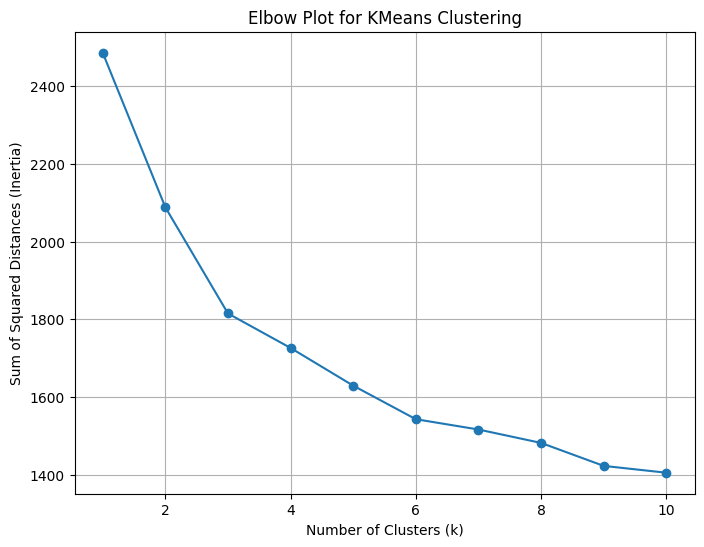

In [10]:
scaler = MinMaxScaler()
numeric_data_normalized = scaler.fit_transform(df[numeric_cols])


encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_data_encoded = encoder.fit_transform(df[categorical_cols])


numeric_data_normalized = np.nan_to_num(numeric_data_normalized, nan=0.0)
categorical_data_encoded = np.nan_to_num(categorical_data_encoded, nan=0.0)


clustering_data = np.hstack([numeric_data_normalized, categorical_data_encoded])


sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Plot for KMeans Clustering')
plt.grid()
plt.show()

In [11]:

kmeans_3 = KMeans(n_clusters=3, random_state=42)
cluster_labels_3 = kmeans_3.fit_predict(clustering_data)

kmeans_6 = KMeans(n_clusters=6, random_state=42)
cluster_labels_6 = kmeans_6.fit_predict(clustering_data)


df_combined['Cluster_3'] = cluster_labels_3
df_combined['Cluster_6'] = cluster_labels_6

Classification Report for 3 Clusters:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       0.97      0.98      0.98        65
           2       0.99      0.96      0.97        71

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



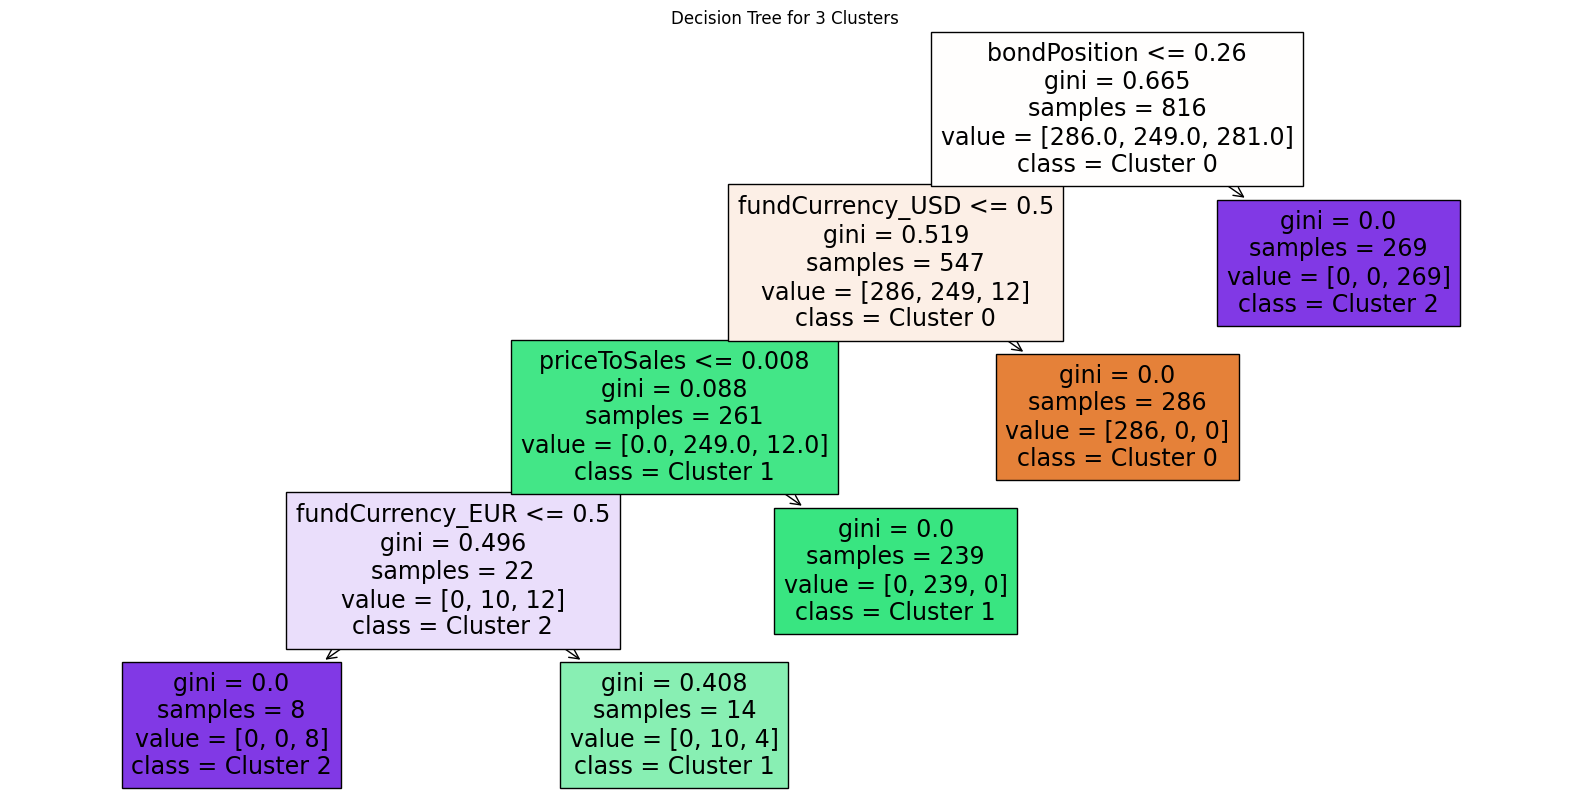

In [13]:

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(clustering_data, cluster_labels_3, test_size=0.2, random_state=42)
tree_3 = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_3.fit(X_train_3, y_train_3)


y_pred_3 = tree_3.predict(X_test_3)
print("Classification Report for 3 Clusters:")
print(classification_report(y_test_3, y_pred_3))


encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(encoded_feature_names)


if len(all_feature_names) != clustering_data.shape[1]:
    raise ValueError(f"Feature names length ({len(all_feature_names)}) does not match the data dimensions ({clustering_data.shape[1]}).")


plt.figure(figsize=(20, 10))
plot_tree(
    tree_3,
    feature_names=all_feature_names,
    class_names=['Cluster 0', 'Cluster 1', 'Cluster 2'],
    filled=True
)
plt.title("Decision Tree for 3 Clusters")
plt.show()

Classification Report for 6 Clusters:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        41

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



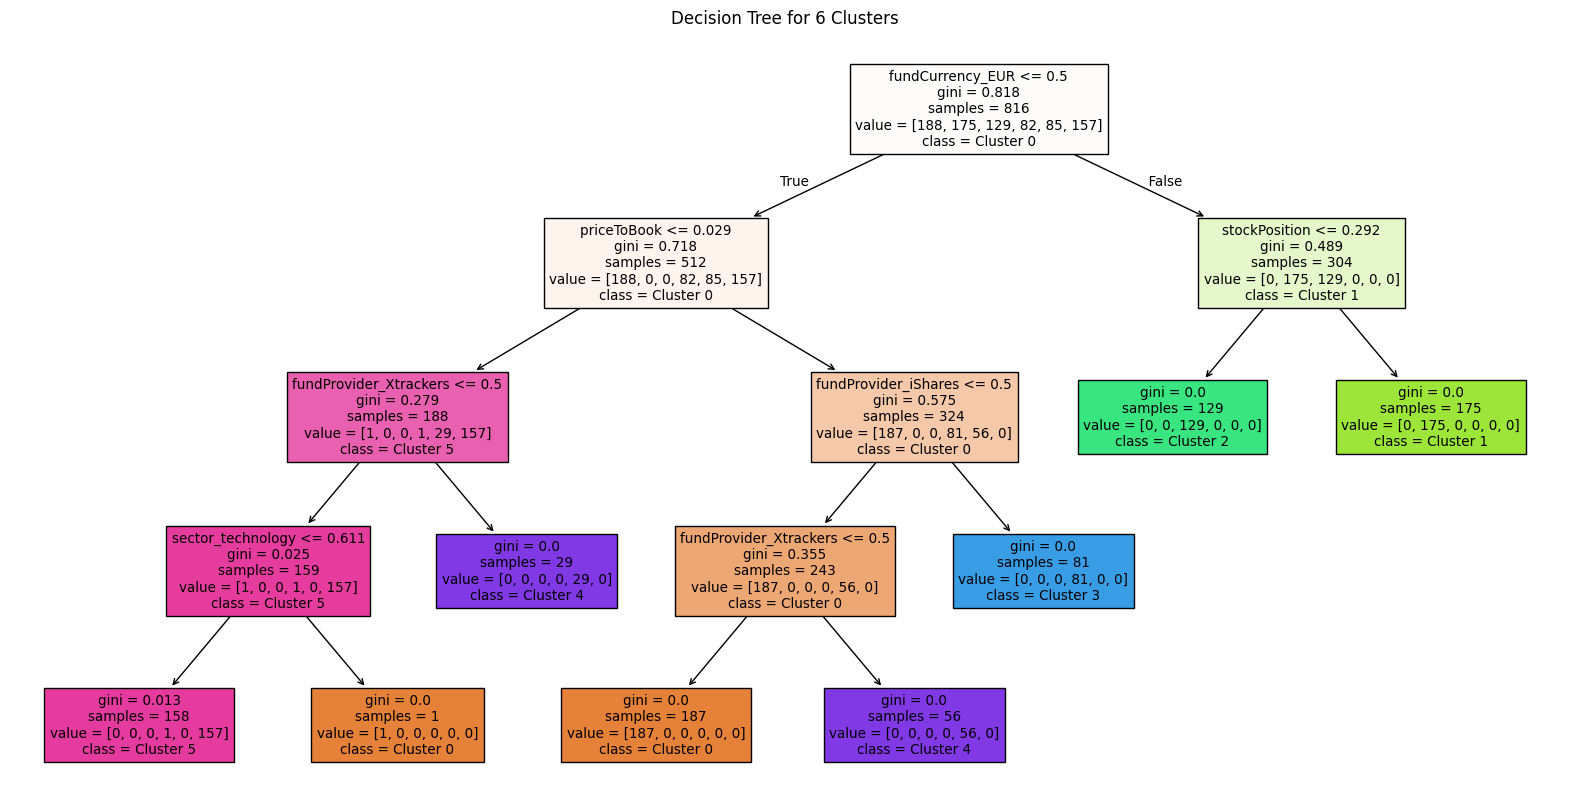

In [14]:

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(clustering_data, cluster_labels_6, test_size=0.2, random_state=42)
tree_6 = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_6.fit(X_train_6, y_train_6)


y_pred_6 = tree_6.predict(X_test_6)
print("Classification Report for 6 Clusters:")
print(classification_report(y_test_6, y_pred_6))

encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(encoded_feature_names)


if len(all_feature_names) != clustering_data.shape[1]:
    raise ValueError(f"Feature names length ({len(all_feature_names)}) does not match the data dimensions ({clustering_data.shape[1]}).")


plt.figure(figsize=(20, 10))
plot_tree(
    tree_6,
    feature_names=all_feature_names,
    class_names=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    filled=True
)
plt.title("Decision Tree for 6 Clusters")
plt.show()

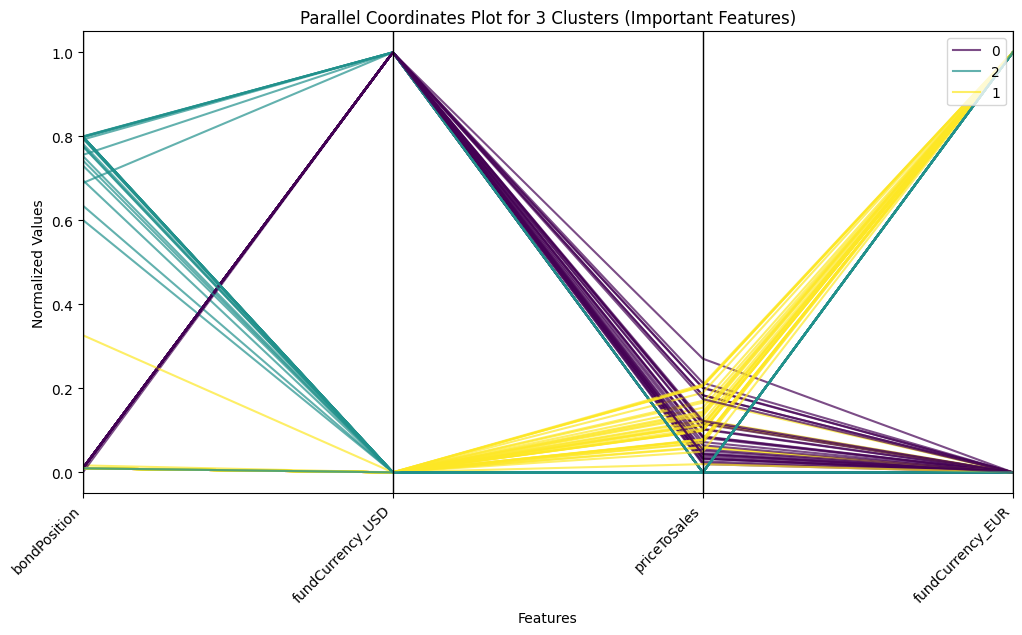

In [16]:

important_features_3 = ['bondPosition', 'fundCurrency_USD', 'priceToSales', 'fundCurrency_EUR']


parallel_data_3 = pd.DataFrame(clustering_data, columns=numeric_cols + list(encoded_feature_names))
parallel_data_3 = parallel_data_3[important_features_3]
parallel_data_3['Cluster'] = df_combined['Cluster_3']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data_3.sample(frac=0.1, random_state=42), class_column='Cluster', colormap='viridis', alpha=0.7)
plt.title('Parallel Coordinates Plot for 3 Clusters (Important Features)')
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

3 Cluster Approach Analysis:

Cluster 0:
- Characteristics: High bond positions, primarily USD funds, moderate price-to-sales ratios.
- Ideal Investor: Conservative, income-focused investors seeking stability and low risk.
- Example ETF: BNP Paribas Easy MSCI World ESG Filtered Min TE (BNP Paribas Easy, USD)

Cluster 1:
- Characteristics: Balanced equity-focused funds, predominantly EUR, with higher price-to-sales ratios.
- Ideal Investor: Growth-oriented, moderate risk investors targeting European equity markets.
- Example ETF: SPDR MSCI EMU UCITS ETF (SPDR ETF, EUR)

Cluster 2:
- Characteristics: Bond-heavy ETFs with GBP/EUR focus, very low price-to-sales ratios.
- Ideal Investor: Low-risk investors prioritizing regional bond diversification.
- Example ETF: iShares Core UK Gilts UCITS ETF (iShares, GBP)

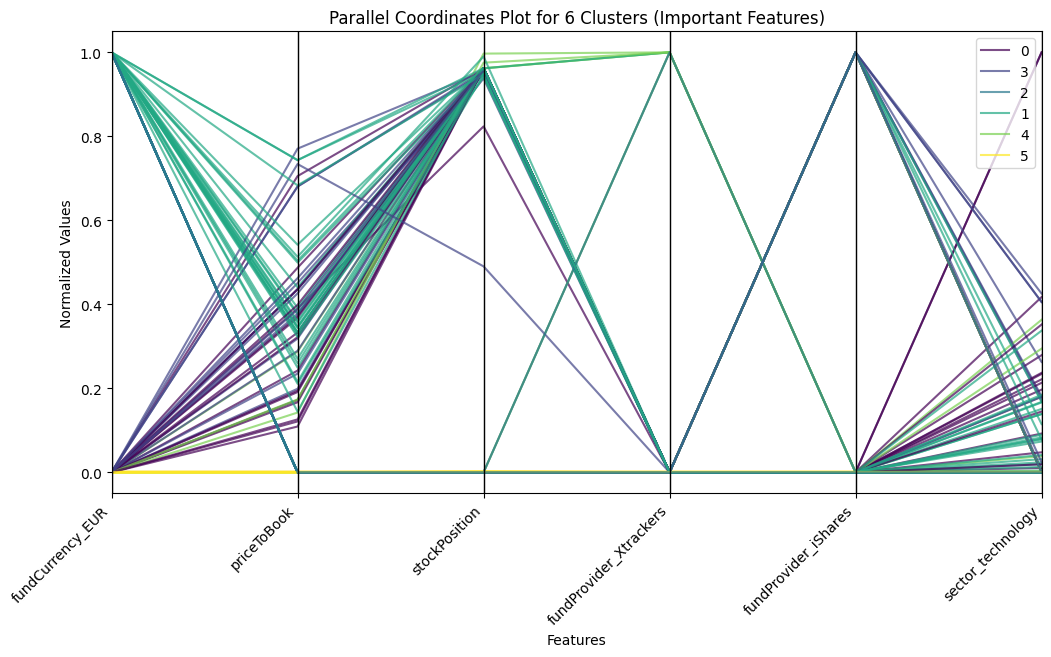

In [17]:
important_features_6 = ['fundCurrency_EUR', 'priceToBook', 'stockPosition', 'fundProvider_Xtrackers', 'fundProvider_iShares', 'sector_technology']

parallel_data_6 = pd.DataFrame(clustering_data, columns=numeric_cols + list(encoded_feature_names))
parallel_data_6 = parallel_data_6[important_features_6]
parallel_data_6['Cluster'] = df_combined['Cluster_6']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data_6.sample(frac=0.1, random_state=42), class_column='Cluster', colormap='viridis', alpha=0.7)
plt.title('Parallel Coordinates Plot for 6 Clusters (Important Features)')
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [18]:
print("\nSample ETFs for 3 Clusters:")
for cluster in range(3):
    print(f"\nCluster {cluster}:")
    cluster_data_3 = df_combined[df_combined['Cluster_3'] == cluster]
    sample_etfs_3 = cluster_data_3[['name', 'fundProvider', 'fundCurrency']].sample(n=min(3, len(cluster_data_3)), random_state=42)
    display(sample_etfs_3)

print("\nSample ETFs for 6 Clusters:")
for cluster in range(6):
    print(f"\nCluster {cluster}:")
    cluster_data_6 = df_combined[df_combined['Cluster_6'] == cluster]
    sample_etfs_6 = cluster_data_6[['name', 'fundProvider', 'fundCurrency']].sample(n=min(3, len(cluster_data_6)), random_state=42)
    display(sample_etfs_6)


Sample ETFs for 3 Clusters:

Cluster 0:


,name,fundProvider,fundCurrency
781,BNP Paribas Easy MSCI World ESG Filtered Min T...,BNP Paribas Easy,USD
341,Fidelity US Quality Income UCITS ETF,Fidelity ETF,USD
823,HSBC Nasdaq Global Semiconductor UCITS ETF,HSBC ETF,USD



Cluster 1:


,name,fundProvider,fundCurrency
611,SPDR MSCI EMU UCITS ETF,SPDR ETF,EUR
283,Lyxor Dow Jones Industrial Average UCITS ETF -...,Lyxor ETF,EUR
773,Amundi MSCI World Energy UCITS ETF EUR (C),Amundi ETF,EUR



Cluster 2:


,name,fundProvider,fundCurrency
363,iShares Core UK Gilts UCITS ETF,iShares,GBP
130,BNP Paribas Easy EUR Corporate Bond SRI Fossil...,BNP Paribas Easy,EUR
68,Lyxor Euro Government Bond 7-10Y (DR) UCITS ET...,Lyxor ETF,EUR



Sample ETFs for 6 Clusters:

Cluster 0:


,name,fundProvider,fundCurrency
954,Global X Video Games & Esports UCITS ETF Acc USD,Global X,USD
444,Franklin FTSE Korea UCITS ETF,Franklin Templeton,USD
286,Lyxor DJ Switzerland Titans 30 (DR) UCITS ETF,Lyxor ETF,CHF



Cluster 1:


,name,fundProvider,fundCurrency
986,Invesco European Telecoms Sector UCITS ETF,Invesco,EUR
388,HSBC Europe Sustainable Equity UCITS ETF EUR,HSBC ETF,EUR
234,BNP Paribas Easy ESG Value Europe UCITS ETF,BNP Paribas Easy,EUR



Cluster 2:


,name,fundProvider,fundCurrency
501,VanEck iBoxx EUR Corporates UCITS ETF,VanEck,EUR
474,Amundi Floating Rate Euro Corporate ESG UCITS ...,Amundi ETF,EUR
493,Deka iBoxx EUR Liquid Sovereign Diversified 1-...,Deka ETFs,EUR



Cluster 3:


,name,fundProvider,fundCurrency
958,iShares Metaverse UCITS ETF USD (Acc),iShares,USD
360,iShares FTSE 250 UCITS ETF,iShares,GBP
282,iShares Dow Jones Industrial Average UCITS ETF...,iShares,USD



Cluster 4:


,name,fundProvider,fundCurrency
824,Xtrackers Nifty 50 Swap UCITS ETF 1C,Xtrackers,USD
792,Xtrackers MSCI World ESG UCITS ETF 2C EUR Hedged,Xtrackers,EUR Hedged
776,Xtrackers MSCI World Value Factor UCITS ETF 1C,Xtrackers,USD



Cluster 5:


,name,fundProvider,fundCurrency
162,Lyxor USD Corporade Bond UCITS ETF - Monthly H...,Lyxor ETF,EUR Hedged
218,Invesco US Treasury Bond 0-1 Year UCITS ETF EU...,Invesco,EUR Hedged
24,Invesco Emerging Markets USD Bond UCITS ETF Dist,Invesco,USD


### 6 Cluster Approach Analysis:

Cluster 0:
- Vibe: Non-European ETFs with high exposure to the tech sector, balanced price-to-book values, and typically not dominated by Xtrackers or iShares.
- Example ETF: Global X Video Games & Esports UCITS ETF.
- Ideal User: Tech-oriented, growth-focused investors seeking global exposure outside of Europe.

Cluster 1:
- Vibe: European equity-heavy ETFs with high stock positions and EUR-dominated currencies.
- Example ETF: HSBC Europe Sustainable Equity UCITS ETF.
- Ideal User: Investors focused on European equity markets, comfortable with higher risk and volatility.

Cluster 2:
- Vibe: European bond-heavy ETFs with low stock exposure, EUR-dominated currencies, and conservative risk profiles.
- Example ETF: VanEck iBoxx EUR Corporates UCITS ETF.
- Ideal User: Conservative investors looking for stability and income in European bond markets.

Cluster 3:
- Vibe: Non-European ETFs with high price-to-book values, often dominated by iShares and offering growth-oriented opportunities.
- Example ETF: iShares Metaverse UCITS ETF.
- Ideal User: Growth-focused investors targeting high-value, innovation-driven sectors outside of Europe.

Cluster 4:
- Vibe: Mixed price-to-book ETFs typically dominated by Xtrackers, with hedged or USD-based currencies and balanced risk profiles.
- Example ETF: Xtrackers MSCI World ESG UCITS ETF.
- Ideal User: Investors who value diversification and want a mix of global exposure, especially through Xtrackers.

Cluster 5:
- Vibe: Non-Xtrackers ETFs with low price-to-book values, lower tech sector exposure, and a mix of bond and equity positions.
- Example ETF: Lyxor USD Corporate Bond UCITS ETF.
- Ideal User: Moderate-risk investors seeking low-tech, balanced exposure, and a mix of bond and equity holdings.

## Comparing these Clusters to the 6 Clusters made with PCA

The clusters generated by KMeans without PCA and those based on PCA overlap in some cases, particularly in the representation of European bond-heavy ETFs (Cluster 2 in both approaches), which cater to conservative investors seeking stability. Similarly, niche thematic ETFs such as ESG or technology-focused funds appear prominently in both methods, albeit categorized differently (e.g., Cluster 4 in KMeans vs. Clusters 4 and 5 in PCA). However, the features driving these clusters differ significantly. The PCA-based approach highlights dominant variance in the data, often grouping ETFs by fund providers or broad themes, such as Vanguard's low-cost funds (Cluster 0 in PCA). In contrast, KMeans without PCA captures more granular distinctions, such as variations in price-to-book ratios, sector composition, or currency preferences, leading to clusters like Cluster 0 (non-European tech-heavy funds) and Cluster 3 (iShares-dominated high price-to-book ETFs).

These differences arise because PCA compresses the data into a reduced set of components that capture the most variation, prioritizing global patterns and emphasizing dominant trends like fund provider or broad sector themes. On the other hand, clustering raw features without PCA retains the full detail of individual variables, allowing for finer-grained categorizations. While PCA clusters provide a high-level, provider- or theme-focused view, the raw-data clusters reveal more nuanced differences, offering complementary perspectives for identifying unique ETF groupings and tailoring investment strategies.